# Welcome to another notebook for ATOC NWP: Evaluating ensembles

November 16, 2021
Jay.Kong@colorado.edu

# First import all the python modules that might be needed

In [31]:
import os
import csv
import glob
import numpy as np                  # For doing math
import matplotlib
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import matplotlib.colors as colors  # For truncating colorbars
import matplotlib.style as style
import matplotlib.units as munits
import xarray as xr                 # For dealing with netCDF data
import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps
import pandas as pd                 # A quick way to deal with time stamps
import netCDF4 as nc                # Another way to deal with netCDF data

import metpy.calc as mpcalc
import datetime
import scipy.interpolate
import scipy.signal as sig
import scipy.stats as stats
import sys
import scipy.io as sio

import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps

from netCDF4 import Dataset
from xarray import DataArray

from scipy.optimize import curve_fit
from matplotlib import colors as mcolors
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec
from numpy.random import seed
from numpy.random import rand
from datetime import datetime
from wrf import (getvar, interplevel, vertcross, 
                 vinterp, ALL_TIMES, extract_global_attrs)

print('Done importing modules now')

import warnings
warnings.filterwarnings('ignore')

Done importing modules now


## Define some useful functions

In [32]:
def getheights(ds):
    '''
    From a dataset of wrfout files, calculate height above the surface
    '''

    heights3d_stag = (ds['PH'].isel(Time=1) + ds['PHB'].isel(Time=1))/9.81 - ds['HGT'].isel(Time=1).values
    heights_stag = heights3d_stag.mean(('south_north', 'west_east')).values

    heights_destag = []
    for i in range(len(heights_stag)-1):
        heights_destag.append(0.5*(heights_stag[i]+heights_stag[i+1]))
    heights_destag = np.array(heights_destag)

    return heights_destag

In [33]:
def destagger(var, stagger_dim):
    '''
    From wrf-python https://github.com/NCAR/wrf-python/blob/b40d1d6e2d4aea3dd2dda03aae18e268b1e9291e/src/wrf/destag.py 
    '''
    var_shape = var.shape
    num_dims = var.ndim
    stagger_dim_size = var_shape[stagger_dim]

    full_slice = slice(None)
    slice1 = slice(0, stagger_dim_size - 1, 1)
    slice2 = slice(1, stagger_dim_size, 1)

    dim_ranges_1 = [full_slice] * num_dims
    dim_ranges_2 = [full_slice] * num_dims

    dim_ranges_1[stagger_dim] = slice1
    dim_ranges_2[stagger_dim] = slice2

    result = .5*(var[tuple(dim_ranges_1)] + var[tuple(dim_ranges_2)])

    return result

# Now open up the datafiles that might be needed

In [34]:
# Define directories to read in and open as xarray

DIR_1 = '/pl/active/courses/2021_fall/ATOC_NWP/students/reba1583/ICA_13/d02_067/'
DIR_2 = '/pl/active/courses/2021_fall/ATOC_NWP/students/sica2947/ICA_13/d02_085/'
DIR_3 = '/pl/active/courses/2021_fall/ATOC_NWP/students/erke2265/ICA_13/d02_148/'
DIR_4 = '/pl/active/courses/2021_fall/ATOC_NWP/students/jiko1138/ICA_13/d02_175/'
DIR_5 = '/pl/active/courses/2021_fall/ATOC_NWP/students/rosa5922/ICA_13/d02_274/'
DIR_6 = '/pl/active/courses/2021_fall/ATOC_NWP/students/jlundqui/ICA_13/d02_301/'
DIR_7 = '/pl/active/courses/2021_fall/ATOC_NWP/students/jiko1138/ICA_13/d02_427/'
DIR_8 = '/pl/active/courses/2021_fall/ATOC_NWP/students/sica2947/ICA_13/d02_517/'

In [35]:
DIR1_label=DIR_1[(DIR_1.find('ICA_13') + 7):]
DIR2_label=DIR_2[(DIR_2.find('ICA_13') + 7):]
DIR3_label=DIR_3[(DIR_3.find('ICA_13') + 7):]
DIR4_label=DIR_4[(DIR_4.find('ICA_13') + 7):]
DIR5_label=DIR_5[(DIR_5.find('ICA_13') + 7):]
DIR6_label=DIR_6[(DIR_6.find('ICA_13') + 7):]
DIR7_label=DIR_7[(DIR_7.find('ICA_13') + 7):]
DIR8_label=DIR_8[(DIR_8.find('ICA_13') + 7):]

In [36]:
filenames_1 = sorted([f for f in glob.glob(DIR_1+"/wrfout_d02_*")])
filenames_2 = sorted([f for f in glob.glob(DIR_2+"/wrfout_d02_*")])
filenames_3 = sorted([f for f in glob.glob(DIR_3+"/wrfout_d02_*")])
filenames_4 = sorted([f for f in glob.glob(DIR_4+"/wrfout_d02_*")])
filenames_5 = sorted([f for f in glob.glob(DIR_5+"/wrfout_d02_*")])
filenames_6 = sorted([f for f in glob.glob(DIR_6+"/wrfout_d02_*")])
filenames_7 = sorted([f for f in glob.glob(DIR_7+"/wrfout_d02_*")])
filenames_8 = sorted([f for f in glob.glob(DIR_8+"/wrfout_d02_*")])

In [37]:
# print(filenames)

ds_1 = xr.open_mfdataset(filenames_1, 
                        concat_dim = 'Time',
                       combine = 'nested',
                       parallel=True)

ds_2 = xr.open_mfdataset(filenames_2, 
                       concat_dim = 'Time',
                      combine = 'nested',
                      parallel=True)

ds_3 = xr.open_mfdataset(filenames_3, 
                       concat_dim = 'Time',
                      combine = 'nested',
                      parallel=True)

ds_4 = xr.open_mfdataset(filenames_4, 
                        concat_dim = 'Time',
                       combine = 'nested',
                       parallel=True)

ds_5 = xr.open_mfdataset(filenames_5, 
                       concat_dim = 'Time',
                      combine = 'nested',
                      parallel=True)

ds_6 = xr.open_mfdataset(filenames_6, 
                       concat_dim = 'Time',
                      combine = 'nested',
                      parallel=True)

ds_7 = xr.open_mfdataset(filenames_7, 
                       concat_dim = 'Time',
                      combine = 'nested',
                      parallel=True)

ds_8 = xr.open_mfdataset(filenames_8, 
                       concat_dim = 'Time',
                      combine = 'nested',
                      parallel=True)

In [38]:
## Extract some useful quantities to explore the data

height_1 = getheights(ds_1)
u_1 = destagger(ds_1['U'], 3)
v_1 = destagger(ds_1['V'], 2)

print('U:',np.shape(u_1))
print('V:',np.shape(v_1))
print('Height:',np.shape(height_1))

height_2 = getheights(ds_2)
u_2 = destagger(ds_2['U'], 3)
v_2 = destagger(ds_2['V'], 2)
ws_2 = (u_2 **2 + v_2 ** 2) ** (0.5)

print('U:',np.shape(u_2))
print('V:',np.shape(v_2))
print('Height:',np.shape(height_2))

height_3 = getheights(ds_3)
u_3 = destagger(ds_3['U'], 3)
v_3 = destagger(ds_3['V'], 2)
ws_3 = (u_3 **2 + v_3 ** 2) ** (0.5)

print('U:',np.shape(u_3))
print('V:',np.shape(v_3))
print('Height:',np.shape(height_3))

height_4 = getheights(ds_4)
u_4 = destagger(ds_4['U'], 3)
v_4 = destagger(ds_4['V'], 2)
ws_4 = (u_4 **2 + v_4 ** 2) ** (0.5)

print('U:',np.shape(u_4))
print('V:',np.shape(v_4))
print('Height:',np.shape(height_4))

height_5 = getheights(ds_5)
u_5 = destagger(ds_5['U'], 3)
v_5 = destagger(ds_5['V'], 2)
ws_5 = (u_5 **2 + v_5 ** 2) ** (0.5)

print('U:',np.shape(u_5))
print('V:',np.shape(v_5))
print('Height:',np.shape(height_5))

height_6 = getheights(ds_6)
u_6 = destagger(ds_6['U'], 3)
v_6 = destagger(ds_6['V'], 2)
ws_6 = (u_6 **2 + v_6 ** 2) ** (0.5)

print('U:',np.shape(u_6))
print('V:',np.shape(v_6))
print('Height:',np.shape(height_6))


height_7 = getheights(ds_7)
u_7 = destagger(ds_7['U'], 3)
v_7 = destagger(ds_7['V'], 2)
ws_7 = (u_7 **2 + v_7 ** 2) ** (0.5)

print('U:',np.shape(u_7))
print('V:',np.shape(v_7))
print('Height:',np.shape(height_7))

height_8 = getheights(ds_8)
u_8 = destagger(ds_8['U'], 3)
v_8 = destagger(ds_8['V'], 2)
ws_8 = (u_8 **2 + v_8 ** 2) ** (0.5)

print('U:',np.shape(u_8))
print('V:',np.shape(v_8))
print('Height:',np.shape(height_8))

#### And height and time:

# print('Heights:',height_2)
# print('Height[7]', height_1[7], ' m')
print('Height[7]', height_2[7], ' m')
print('Height[7]', height_3[7], ' m')
# print('Height[7]', height_4[7], ' m')
bottom_top_index = 7

times_1 = ds_1['XTIME'].values
times_2 = ds_2['XTIME'].values
times_3 = ds_3['XTIME'].values
times_4 = ds_4['XTIME'].values
times_5 = ds_5['XTIME'].values
times_6 = ds_6['XTIME'].values
times_7 = ds_7['XTIME'].values
times_8 = ds_8['XTIME'].values


U: (49, 57, 66, 66)
V: (49, 57, 66, 66)
Height: (57,)
U: (50, 57, 84, 84)
V: (50, 57, 84, 84)
Height: (57,)
U: (49, 57, 147, 147)
V: (49, 57, 147, 147)
Height: (57,)
U: (49, 57, 174, 174)
V: (49, 57, 174, 174)
Height: (57,)
U: (60, 57, 273, 273)
V: (60, 57, 273, 273)
Height: (57,)
U: (49, 57, 300, 300)
V: (49, 57, 300, 300)
Height: (57,)
U: (36, 57, 426, 426)
V: (36, 57, 426, 426)
Height: (57,)
U: (52, 57, 516, 516)
V: (52, 57, 516, 516)
Height: (57,)
Height[7] 98.8966293334961  m
Height[7] 98.73687744140625  m


In [39]:
# The wind speed near the 100-m altitude (probably around 98-m) at the ARM SGP site at 1100 UTC on 9 Oct

# Find the location
desired_lon = -97.485
desired_lat = 36.605

#calculate the distance from the cell center of all cells to the desired location. The
#indices with the minimum distance are the right indices to use.

#what is the closest location in the big domain?
km_lon = 85 #at 25.89 N, 100 km at 40 deg N, 85 km per degree of longitude -- should really use a projection here
km_lat = 111 # 111 km per degree of latitude



print('_____________________________________________________________________________')

xlon_1 = ds_1['XLONG'] 
xlat_1 = ds_1['XLAT']

guess = 0.5 * np.size(xlon_1[0,0,:]) + 1
print(np.round(guess))
south_north_index_1=40 # guess as half the domain dimension+1
west_east_index_1=40
this_lat_1 = ds_1['XLAT'].isel(Time=0,south_north=south_north_index_1,west_east=west_east_index_1)
this_lon_1 = ds_1['XLONG'].isel(Time=0,south_north=south_north_index_1,west_east=west_east_index_1)

print(this_lat_1.values)
print(this_lon_1.values)


dist_1 = np.sqrt(np.square(abs(km_lon*(xlon_1[0,:,:] - desired_lon))) 
                    + np.square(abs(km_lat*(xlat_1[0,:,:] - desired_lat))))
print("Closest point is distance: ",np.round(np.min(dist_1).values,3)," km")

print("This point is distance: ",np.round(np.sqrt(np.square(abs(km_lon*(this_lon_1.values - desired_lon))) 
                    + np.square(abs(km_lat*(this_lat_1.values - desired_lat)))),2), " km")


print('_____________________________________________________________________________')

# Will have to iterate for each of domains that you use. A good guess is the center point..
xlon_2 = ds_2['XLONG'] 
xlat_2 = ds_2['XLAT']

guess = 0.5 * np.size(xlon_2[0,0,:]) + 1
print(np.round(guess))
south_north_index_2=43 # guess as half the domain dimension+1
west_east_index_2=43
this_lat_2 = ds_2['XLAT'].isel(Time=0,south_north=south_north_index_2,west_east=west_east_index_2)
this_lon_2 = ds_2['XLONG'].isel(Time=0,south_north=south_north_index_2,west_east=west_east_index_2)

print(this_lat_2.values)
print(this_lon_2.values)


dist_2 = np.sqrt(np.square(abs(km_lon*(xlon_2[0,:,:] - desired_lon))) 
                    + np.square(abs(km_lat*(xlat_2[0,:,:] - desired_lat))))
print("Closest point is distance: ",np.round(np.min(dist_2).values,3)," km")

print("This point is distance: ",np.round(np.sqrt(np.square(abs(km_lon*(this_lon_2.values - desired_lon))) 
                    + np.square(abs(km_lat*(this_lat_2.values - desired_lat)))),2), " km")

print('_____________________________________________________________________________')

# Will have to iterate for each of domains that you use. A good guess is the center point..
xlon_3 = ds_3['XLONG'] 
xlat_3 = ds_3['XLAT']

guess = 0.5 * np.size(xlon_3[0,0,:]) + 1
print(np.round(guess))
south_north_index_3=61 # guess as half the domain dimension+1
west_east_index_3=61
this_lat_3 = ds_3['XLAT'].isel(Time=0,south_north=south_north_index_3,west_east=west_east_index_3)
this_lon_3 = ds_3['XLONG'].isel(Time=0,south_north=south_north_index_3,west_east=west_east_index_3)

print(this_lat_3.values)
print(this_lon_3.values)


dist_3 = np.sqrt(np.square(abs(km_lon*(xlon_3[0,:,:] - desired_lon))) 
                    + np.square(abs(km_lat*(xlat_3[0,:,:] - desired_lat))))
print("Closest point is distance: ",np.round(np.min(dist_3).values,3)," km")

print("This point is distance: ",np.round(np.sqrt(np.square(abs(km_lon*(this_lon_3.values - desired_lon))) 
                    + np.square(abs(km_lat*(this_lat_3.values - desired_lat)))),2), " km")

print('_____________________________________________________________________________')

# Will have to iterate for each of domains that you use. A good guess is the center point..
xlon_4 = ds_4['XLONG'] 
xlat_4 = ds_4['XLAT']

guess = 0.5 * np.size(xlon_4[0,0,:]) + 1
print(np.round(guess))
south_north_index_4=88 # guess as half the domain dimension+1
west_east_index_4=88
this_lat_4 = ds_4['XLAT'].isel(Time=0,south_north=south_north_index_4,west_east=west_east_index_4)
this_lon_4 = ds_4['XLONG'].isel(Time=0,south_north=south_north_index_4,west_east=west_east_index_4)

print(this_lat_4.values)
print(this_lon_4.values)


dist_4 = np.sqrt(np.square(abs(km_lon*(xlon_4[0,:,:] - desired_lon))) 
                    + np.square(abs(km_lat*(xlat_4[0,:,:] - desired_lat))))
print("Closest point is distance: ",np.round(np.min(dist_4).values,3)," km")

print("This point is distance: ",np.round(np.sqrt(np.square(abs(km_lon*(this_lon_4.values - desired_lon))) 
                    + np.square(abs(km_lat*(this_lat_4.values - desired_lat)))),2), " km")

print('_____________________________________________________________________________')

xlon_5 = ds_5['XLONG'] 
xlat_5 = ds_5['XLAT']

guess = 0.5 * np.size(xlon_5[0,0,:]) + 1
print('Guess 5')
print(np.round(guess))
south_north_index_5=136 # guess as half the domain dimension+1
west_east_index_5=136
this_lat_5 = ds_5['XLAT'].isel(Time=0,south_north=south_north_index_5,west_east=west_east_index_5)
this_lon_5 = ds_5['XLONG'].isel(Time=0,south_north=south_north_index_5,west_east=west_east_index_5)

print(this_lat_5.values)
print(this_lon_5.values)

dist_5 = np.sqrt(np.square(abs(km_lon*(xlon_5[0,:,:] - desired_lon))) 
                    + np.square(abs(km_lat*(xlat_5[0,:,:] - desired_lat))))
print("Closest point is distance: ",np.round(np.min(dist_5).values,3)," km")

print("This point is distance: ",np.round(np.sqrt(np.square(abs(km_lon*(this_lon_5.values - desired_lon))) 
                    + np.square(abs(km_lat*(this_lat_5.values - desired_lat)))),2), " km")

print('_____________________________________________________________________________')

xlon_6 = ds_6['XLONG'] 
xlat_6 = ds_6['XLAT']

guess = 0.5 * np.size(xlon_6[0,0,:]) + 1
print('Guess 6')
print(np.round(guess))
south_north_index_6=166 # guess as half the domain dimension+1
west_east_index_6=166
this_lat_6 = ds_6['XLAT'].isel(Time=0,south_north=south_north_index_6,west_east=west_east_index_6)
this_lon_6 = ds_6['XLONG'].isel(Time=0,south_north=south_north_index_6,west_east=west_east_index_6)

print(this_lat_6.values)
print(this_lon_6.values)

dist_6 = np.sqrt(np.square(abs(km_lon*(xlon_6[0,:,:] - desired_lon))) 
                    + np.square(abs(km_lat*(xlat_6[0,:,:] - desired_lat))))
print("Closest point is distance: ",np.round(np.min(dist_6).values,3)," km")

print("This point is distance: ",np.round(np.sqrt(np.square(abs(km_lon*(this_lon_6.values - desired_lon))) 
                    + np.square(abs(km_lat*(this_lat_6.values - desired_lat)))),2), " km")

print('_____________________________________________________________________________')

xlon_7 = ds_7['XLONG'] 
xlat_7 = ds_7['XLAT']

guess = 0.5 * np.size(xlon_7[0,0,:]) + 1
print('Guess 7')
print(np.round(guess))
south_north_index_7=214 # guess as half the domain dimension+1
west_east_index_7=214
this_lat_7 = ds_7['XLAT'].isel(Time=0,south_north=south_north_index_7,west_east=west_east_index_7)
this_lon_7 = ds_7['XLONG'].isel(Time=0,south_north=south_north_index_7,west_east=west_east_index_7)

print(this_lat_7.values)
print(this_lon_7.values)

dist_7 = np.sqrt(np.square(abs(km_lon*(xlon_7[0,:,:] - desired_lon))) 
                    + np.square(abs(km_lat*(xlat_7[0,:,:] - desired_lat))))
print("Closest point is distance: ",np.round(np.min(dist_7).values,3)," km")

print("This point is distance: ",np.round(np.sqrt(np.square(abs(km_lon*(this_lon_7.values - desired_lon))) 
                    + np.square(abs(km_lat*(this_lat_7.values - desired_lat)))),2), " km")

print('_____________________________________________________________________________')

xlon_8 = ds_8['XLONG'] 
xlat_8 = ds_8['XLAT']

guess = 0.5 * np.size(xlon_8[0,0,:]) + 1
print('Guess 8')
print(np.round(guess))
south_north_index_8=265 # guess as half the domain dimension+1
west_east_index_8=265
this_lat_8 = ds_8['XLAT'].isel(Time=0,south_north=south_north_index_8,west_east=west_east_index_8)
this_lon_8 = ds_8['XLONG'].isel(Time=0,south_north=south_north_index_8,west_east=west_east_index_8)

print(this_lat_8.values)
print(this_lon_8.values)

dist_8 = np.sqrt(np.square(abs(km_lon*(xlon_8[0,:,:] - desired_lon))) 
                    + np.square(abs(km_lat*(xlat_8[0,:,:] - desired_lat))))
print("Closest point is distance: ",np.round(np.min(dist_8).values,3)," km")

print("This point is distance: ",np.round(np.sqrt(np.square(abs(km_lon*(this_lon_8.values - desired_lon))) 
                    + np.square(abs(km_lat*(this_lat_8.values - desired_lat)))),2), " km")

print('_____________________________________________________________________________')

_____________________________________________________________________________
34.0
36.769432
-97.276794
Closest point is distance:  0.003  km
This point is distance:  25.42  km
_____________________________________________________________________________
43.0
36.605022
-97.485016
Closest point is distance:  0.003  km
This point is distance:  0.0  km
_____________________________________________________________________________
74.0
36.19242
-98.000916
Closest point is distance:  0.003  km
This point is distance:  63.41  km
_____________________________________________________________________________
88.0
36.605022
-97.485016
Closest point is distance:  0.003  km
This point is distance:  0.0  km
_____________________________________________________________________________
Guess 5
138.0
36.605022
-97.484985
Closest point is distance:  0.003  km
This point is distance:  0.0  km
_____________________________________________________________________________
Guess 6
151.0
37.01536
-96.96246
Cl

In [ ]:
time_index = 36
print(times_2[time_index])

# print('Heights:',height_2)
print('Height[7]', np.round(height_2[7],2), ' m')
bottom_top_index = 7

this_u_4 = u_4.isel(Time=time_index,south_north=south_north_index_4,west_east_stag=west_east_index_4,bottom_top=bottom_top_index).values
this_v_4 = v_4.isel(Time=time_index,south_north_stag=south_north_index_4,west_east=west_east_index_4,bottom_top=bottom_top_index).values
this_ws_4 = (this_u_4 **2 + this_v_4 **2) ** (0.5)
this_z = np.round(height_4[bottom_top_index],2)

print('U at ',times_4[time_index],' and height ',
      this_z,' m is ',
      np.round(this_u_4,2))
print('V at ',times_4[time_index],' and height ',
      this_z,' m is ',
      np.round(this_v_4,2))
print('For ',DIR4_label,', Wind Speed at ',times_4[time_index],' and height ',
      this_z,' m is ',
      np.round(this_ws_4,2), 'm s-1')

this_u_7 = u_7.isel(Time=time_index,south_north=south_north_index_7,west_east_stag=west_east_index_7,bottom_top=bottom_top_index).values
this_v_7 = v_7.isel(Time=time_index,south_north_stag=south_north_index_7,west_east=west_east_index_7,bottom_top=bottom_top_index).values
this_ws_7 = (this_u_7 **2 + this_v_7 **2) ** (0.5)
this_z = np.round(height_7[bottom_top_index],2)

print('U at ',times_7[time_index],' and height ',
      this_z,' m is ',
      np.round(this_u_7,2))
print('V at ',times_7[time_index],' and height ',
      this_z,' m is ',
      np.round(this_v_7,2))
print('For ',DIR7_label,', Wind Speed at ',times_7[time_index],' and height ',
      this_z,' m is ',
      np.round(this_ws_7,2), 'm s-1')

In [12]:
# The averaged 100-m wind speed from 0700 UTC on 8 October to 0000 UTC on 10 October

this_u_1 = u_1.isel(south_north=south_north_index_1,west_east_stag=west_east_index_1,bottom_top=bottom_top_index)
this_v_1 = v_1.isel(south_north_stag=south_north_index_1,west_east=west_east_index_1,bottom_top=bottom_top_index)
these_ws_1 = (this_u_1[7:].values **2 + this_v_1[7:].values **2 ) ** 0.5

In [13]:
this_u_2 = u_2.isel(south_north=south_north_index_2,west_east_stag=west_east_index_2,bottom_top=bottom_top_index)
this_v_2 = v_2.isel(south_north_stag=south_north_index_2,west_east=west_east_index_2,bottom_top=bottom_top_index)
these_ws_2 = (this_u_2[7:].values **2 + this_v_2[7:].values **2 ) ** 0.5

In [14]:
this_u_3 = u_3.isel(south_north=south_north_index_3,west_east_stag=west_east_index_3,bottom_top=bottom_top_index)
this_v_3 = v_3.isel(south_north_stag=south_north_index_3,west_east=west_east_index_3,bottom_top=bottom_top_index)
these_ws_3 = (this_u_3[7:].values **2 + this_v_3[7:].values **2 ) ** 0.5

this_u_4 = u_4.isel(south_north=south_north_index_4,west_east_stag=west_east_index_4,bottom_top=bottom_top_index)
this_v_4 = v_4.isel(south_north_stag=south_north_index_4,west_east=west_east_index_4,bottom_top=bottom_top_index)
these_ws_4 = (this_u_4[7:].values **2 + this_v_4[7:].values **2 ) ** 0.5

In [15]:
this_u_5 = u_5.isel(south_north=south_north_index_5,west_east_stag=west_east_index_5,bottom_top=bottom_top_index)
this_v_5 = v_5.isel(south_north_stag=south_north_index_5,west_east=west_east_index_5,bottom_top=bottom_top_index)
these_ws_5 = (this_u_5[7:].values **2 + this_v_5[7:].values **2 ) ** 0.5
this_z5 = np.round(height_5[bottom_top_index],2)

this_u_6 = u_6.isel(south_north=south_north_index_6,west_east_stag=west_east_index_6,bottom_top=bottom_top_index)
this_v_6 = v_6.isel(south_north_stag=south_north_index_6,west_east=west_east_index_6,bottom_top=bottom_top_index)
these_ws_6 = (this_u_6[7:].values **2 + this_v_6[7:].values **2 ) ** 0.5
this_z6 = np.round(height_6[bottom_top_index],2)

In [16]:
this_u_7 = u_7.isel(south_north=south_north_index_7,west_east_stag=west_east_index_7,bottom_top=bottom_top_index)
this_v_7 = v_7.isel(south_north_stag=south_north_index_7,west_east=west_east_index_7,bottom_top=bottom_top_index)
these_ws_7 = (this_u_7[7:].values **2 + this_v_7[7:].values **2 ) ** 0.5
this_z7 = np.round(height_7[bottom_top_index],2)

In [ ]:
this_u_8 = u_8.isel(south_north=south_north_index_8,west_east_stag=west_east_index_8,bottom_top=bottom_top_index)
this_v_8 = v_8.isel(south_north_stag=south_north_index_8,west_east=west_east_index_8,bottom_top=bottom_top_index)
these_ws_8 = (this_u_8[7:].values **2 + this_v_8[7:].values **2 ) ** 0.5
this_8 = np.round(height_8[bottom_top_index],2)

In [17]:
print('For ',DIR4_label,', Mean Wind Speed from ',times_4[7],'on, at height ',
      this_z,' m is ',
      np.round(np.mean(these_ws_4),2), 'm s-1')

print('For ',DIR7_label,', Mean Wind Speed from ',times_7[7],'on, at height ',
      this_z,' m is ',
      np.round(np.mean(these_ws_7),2), 'm s-1')

print('Complete')

For  d02_175/ , Mean Wind Speed from  2012-10-08T07:00:00.000000000 on, at height  98.82  m is  10.01 m s-1
For  d02_427/ , Mean Wind Speed from  2012-10-08T07:00:00.000000000 on, at height  98.82  m is  10.27 m s-1
Complete


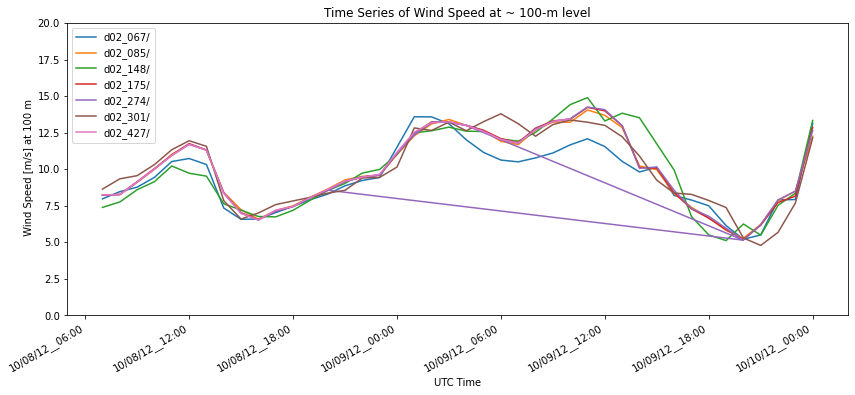

In [16]:
# Time Series plot

fig, ax = plt.subplots(1, 1, figsize=(14,7))

ax.plot(times_1[7:], these_ws_1, label=DIR1_label)
ax.plot(times_2[7:], these_ws_2, label=DIR2_label)
ax.plot(times_3[7:], these_ws_3, label=DIR3_label)
ax.plot(times_4[7:], these_ws_4, label=DIR4_label)
ax.plot(times_5[7:], these_ws_5, label=DIR5_label)
ax.plot(times_6[7:], these_ws_6, label=DIR6_label)
ax.plot(times_7[7:], these_ws_7, label=DIR7_label)
# ax.plot(times_8[7:], these_ws_8, label=DIR8_label)

ax.legend()
ax.set_title('Time Series of Wind Speed at ~ 100-m level')
ax.set_ylabel(" Wind Speed [m/s] at 100 m")
ax.set_xlabel("UTC Time")
ax.set_ylim(0,20)

plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%D__%H:%M')
ax.xaxis.set_major_formatter(myFmt)

plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig("Max_ws_timeseries.pdf")

plt.show()

In [44]:
# And a profile plot
time_index=35
this_u_1 = u_1.isel(Time=time_index,south_north=south_north_index_1,west_east_stag=west_east_index_1)
this_v_1 = v_1.isel(Time=time_index,south_north_stag=south_north_index_1,west_east=west_east_index_1)
these_ws_1 = (this_u_1.values **2 + this_v_1.values **2 ) ** 0.5

this_u_2 = u_2.isel(Time=time_index,south_north=south_north_index_2,west_east_stag=west_east_index_2)
this_v_2 = v_2.isel(Time=time_index,south_north_stag=south_north_index_2,west_east=west_east_index_2)
these_ws_2 = (this_u_2.values **2 + this_v_2.values **2 ) ** 0.5

this_u_3 = u_3.isel(Time=time_index,south_north=south_north_index_3,west_east_stag=west_east_index_3)
this_v_3 = v_3.isel(Time=time_index,south_north_stag=south_north_index_3,west_east=west_east_index_3)
these_ws_3 = (this_u_3.values **2 + this_v_3.values **2 ) ** 0.5

this_u_4 = u_4.isel(Time=time_index,south_north=south_north_index_4,west_east_stag=west_east_index_4)
this_v_4 = v_4.isel(Time=time_index,south_north_stag=south_north_index_4,west_east=west_east_index_4)
these_ws_4 = (this_u_4.values **2 + this_v_4.values **2 ) ** 0.5

this_u_5 = u_5.isel(Time=time_index,south_north=south_north_index_5,west_east_stag=west_east_index_5)
this_v_5 = v_5.isel(Time=time_index,south_north_stag=south_north_index_5,west_east=west_east_index_5)
these_ws_5 = (this_u_5.values **2 + this_v_5.values **2 ) ** 0.5

this_u_6 = u_6.isel(Time=time_index,south_north=south_north_index_6,west_east_stag=west_east_index_6)
this_v_6 = v_6.isel(Time=time_index,south_north_stag=south_north_index_6,west_east=west_east_index_6)
these_ws_6 = (this_u_6.values **2 + this_v_6.values **2 ) ** 0.5

this_u_7 = u_7.isel(Time=time_index,south_north=south_north_index_7,west_east_stag=west_east_index_7)
this_v_7 = v_7.isel(Time=time_index,south_north_stag=south_north_index_7,west_east=west_east_index_7)
these_ws_7 = (this_u_7.values **2 + this_v_7.values **2 ) ** 0.5

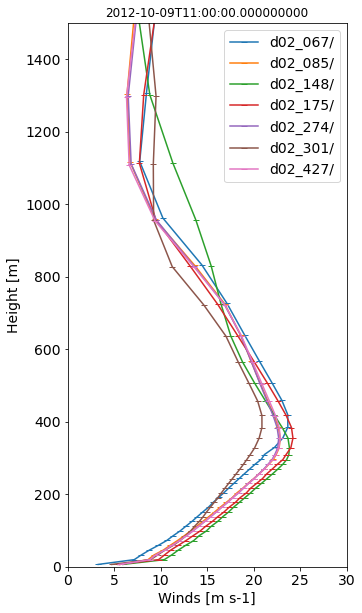

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(5,10))

ax.plot(these_ws_1, height_1, label=DIR1_label, marker = '_')
ax.plot(these_ws_2, height_2, label=DIR2_label, marker = '_')
ax.plot(these_ws_3, height_3, label=DIR3_label, marker = '_')
ax.plot(these_ws_4, height_4, label=DIR4_label, marker = '_')
ax.plot(these_ws_5, height_5, label=DIR5_label, marker = '_')
ax.plot(these_ws_6, height_6, label=DIR6_label, marker = '_')
ax.plot(these_ws_7, height_7, label=DIR7_label, marker = '_')

ax.legend(fontsize=14)
ax.set_ylabel("Height [m]", fontsize=14)
ax.set_xlabel("Winds [m s-1]", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_ylim(0,1500)
ax.set_xlim(0,30)
ax.set_title(times_2[time_index])


plt.show()